# Example Exploration of Mapped Data

This notebook provides a simple set of examples of things to do with the mapped data products from the `PINK SOM`. It aims to demonstrate how to use some of the example classes and perform basic transformations and clustering. Not meant to be a be-all-end-all cookbook. 

In [1]:
import pickle 
import os, shutil

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
from tqdm import tqdm
from scipy.ndimage import rotate
from scipy.stats import gaussian_kde
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.table import Table
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u

import pyink as pu


In [2]:
path = pu.PathHelper('Example_Images', clobber=True)
suffix = 'B3Circular_h8_w8_emu.bin'
image_binary = 'EMU_WISE_E95E05_Aegean_Components_Complex_islandNorm_Log_Reprojected.bin'

(2, 1, 0, 0, 2, (8, 8), 0, 3, (2, 213, 213))
(2, 1704, 1704)


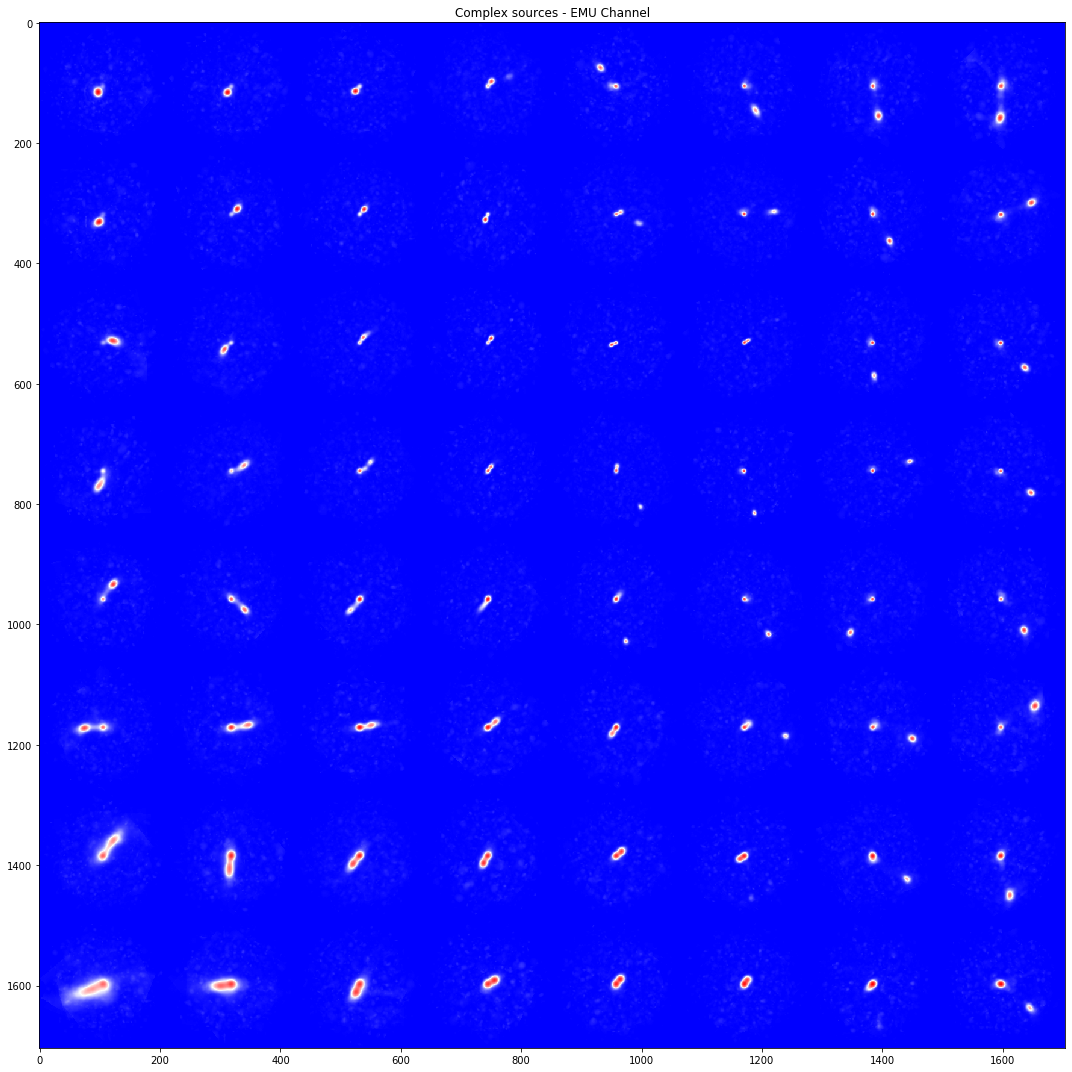

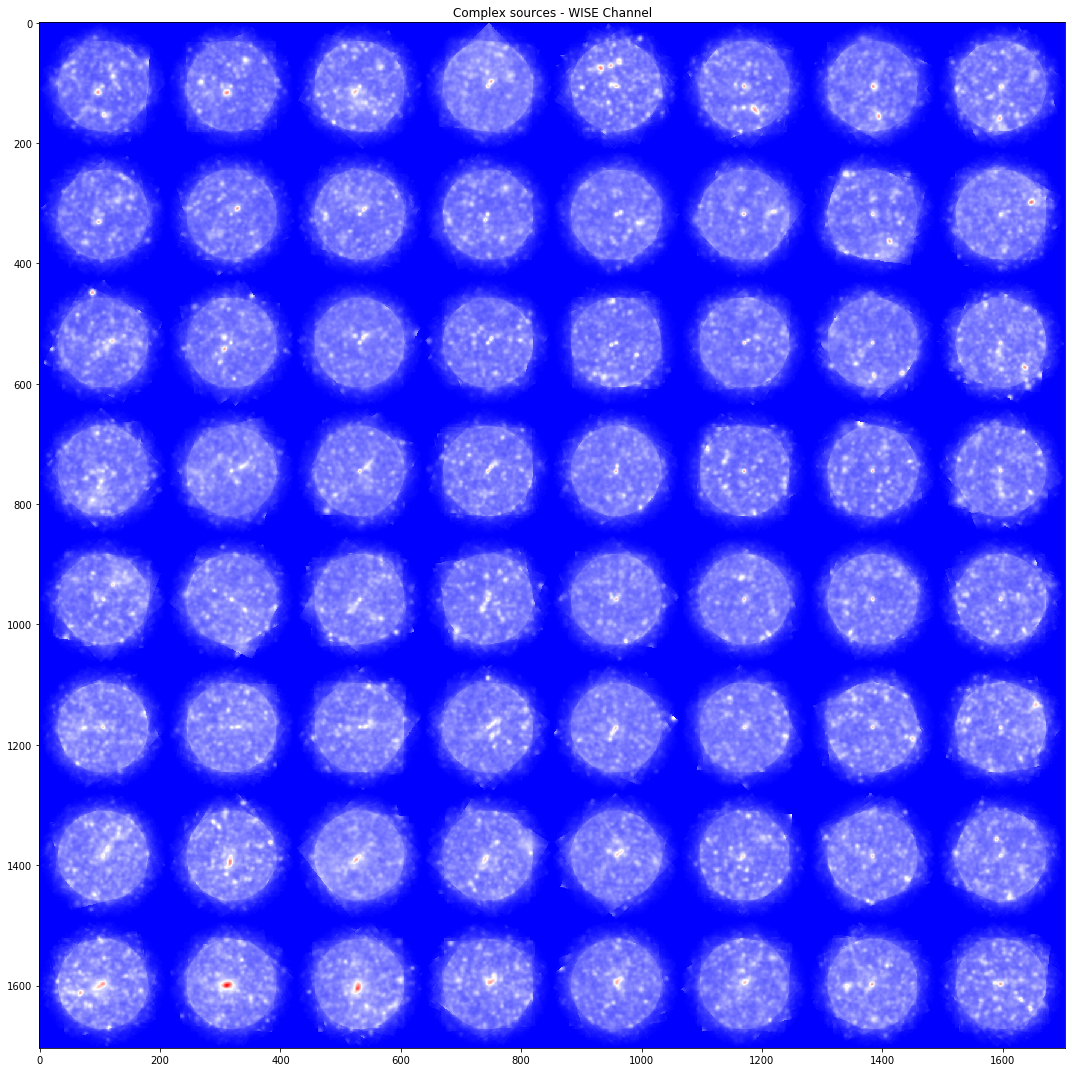

In [3]:
som = pu.SOM(f'SOMs/SOM_{suffix}')

print(som.header)
print(som.data.shape)

d = som.data.copy()

fig, ax = plt.subplots(1,1,figsize=(15,15))

ax.imshow(np.squeeze(d[0,:,:]), cmap='bwr')

ax.set_title('Complex sources - EMU Channel')
fig.tight_layout()
fig.savefig(f'{path}/EMU_Complex_EMU_Channel.png')

fig, ax = plt.subplots(1,1,figsize=(15,15))

ax.imshow(np.squeeze(d[1,:,:]), cmap='bwr')

ax.set_title('Complex sources - WISE Channel')
fig.tight_layout()
fig.savefig(f'{path}/EMU_Complex_WISE_Channel.png')



In [4]:
plt.close('all')

for i, k in enumerate(som):
    d = som[k].copy()

    d[d.min() == d] = np.nan
    
    fig, ax1 = plt.subplots(1,1)

    ax1.imshow(np.squeeze(d[0, :,:]), cmap='bwr')        
   
    ax1.set(title=k)

    fig.tight_layout()
    fig.savefig(f"{path.neurons}/{k}.png")
    plt.close(fig)
    
print('Done')

Done


In [5]:
transform = pu.Transform(f'SOMs/TRANSFORM_{suffix}')
print(transform.header)
print(transform.data.shape)
print('---\n')

mapper = pu.Mapping(f'SOMs/MAP_{suffix}')
print(mapper.header)
print(mapper.data.shape)
print(mapper.bmu().shape)
print('---\n')

imgs = pu.ImageReader(image_binary, record_path='EMU_WISE_E95E05_Aegean_Components_Complex_islandNorm_Log_Reprojected.bin.order.pkl')
print(imgs.header)
print(imgs.data.shape)
print('---\n')


(2, 3, 21437, 0, 2, (8, 8))
(21437, 8, 8)
---

(2, 2, 0, 21437, 0, 2, (8, 8))
(21437, 8, 8)
(21437, 2)
---

(2, 0, 0, 21437, 0, 3, (2, 150, 150))
(21437, 2, 150, 150)
---



In [6]:
plt.close('all')

bad = mapper.data.reshape(mapper.data.shape[0],-1)
bad = bad.min(axis=1)
args = bad.argsort()

for i, idx in enumerate(args[::-1]):
    if i > 100:
        break
    
    fig, ax1 = plt.subplots(1,1)
    
    ax1.imshow(imgs.data[idx, 0])
    
    fig.savefig(f"{path.Weird}/weird_{i}.pdf")
    plt.close(fig)

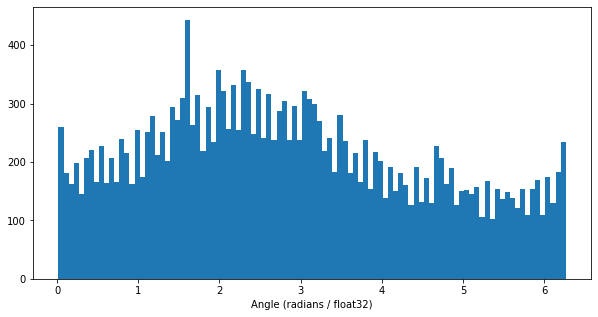

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
bmus = mapper.bmu()[:]

datas = transform.data[:][np.arange(transform.data.shape[0]), bmus[:, 0], bmus[:, 1]]

ax.hist(datas['angle'].flatten(), bins=100)
ax.set(xlabel='Angle (radians / float32)')

fig.savefig(f'{path}/Angles.png')

In [8]:
def pink_rotation(src, angle):
    width_margin = 0
    height_margin = 0

    rot = np.zeros_like(src)
    
    x0 = src.shape[1] // 2
    y0 = src.shape[0] // 2

    cos_alpha = np.cos(angle)
    sin_alpha = np.sin(angle)

    for x2 in range(src.shape[1]):
        for y2 in range(src.shape[0]):
            x1 = (x2 + width_margin - x0) * cos_alpha + (y2 + height_margin - y0) * sin_alpha + x0 + 0.1
            if x1 < 0 or int(x1) >= src.shape[1]:
                rot[y2, x2] = 0
                continue

            y1 = (y2 + height_margin - y0) * cos_alpha - (x2 + width_margin - x0) * sin_alpha + y0 + 0.1
            if y1 < 0 or int(y1) >= src.shape[0]:
                rot[y2, x2] = 0
                continue

            ix1 = int(x1)
            iy1 = int(y1)
            ix1b = int(ix1 + 1)
            iy1b = int(iy1 + 1)
            rx1 = int(x1 - ix1)
            ry1 = int(y1 - iy1)
            cx1 = int(1. - rx1)
            cy1 = int(1. - ry1)

            if max(iy1, ix1, iy1b, ix1b) >= 150:
                continue

            rot[y2, x2] = cx1 * cy1 * src[iy1, ix1] +\
                          cx1 * ry1 * src[iy1b, ix1] +\
                          rx1 * cy1 * src[iy1, ix1b] +\
                          rx1 * ry1 * src[iy1b, ix1b]
            
    return rot

In [9]:
def euclidean_dist(img_a, img_b):
    return np.sum((img_a - img_b)**2.)

def manual_transform(img_idx, imgs, mapper, transform, som, rot_axes=(1,0),
                     pink_rotate=False, verbose=True, plot=True):
    """Given a best matching neuron and an image, compute the best matching spatial transform outside of PINK.
    """
    
    src_img = imgs.data[img_idx, 0]
    bmu_min = mapper.bmu(img_idx)
    bmu_img = som[bmu_min][0]
    bmu_trans = transform.data[(img_idx, *bmu_min)]
    bmu_ed   = mapper.data[(img_idx, *bmu_min)]

    src_mask = pu.square_mask(src_img, 106)
    bmu_mask = pu.square_mask(bmu_img, 106)
    
    if plot:
        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(src_img[src_mask].reshape(106,106))
        ax[1].imshow(bmu_img[bmu_mask].reshape(106,106))

        fig.show()
    
    no_rots = 360
    do_flip = True
    residuals = np.zeros(no_rots * (do_flip+1))
    radian_step = 2*np.pi / no_rots
    
    offset = no_rots // 4
    
    for i in range(offset):
        ang = radian_step * i
        
        if pink_rotate:
            rot_img = pink_rotation(src_img, ang)
        else:
            rot_img = rotate(src_img, -np.rad2deg(ang), reshape=False, order=1)

        residuals[i] = euclidean_dist(rot_img[src_mask], bmu_img[bmu_mask])        
        
        rot_img_90 = np.rot90(rot_img, axes=rot_axes)
        residuals[i+offset] = euclidean_dist(rot_img_90[src_mask], bmu_img[bmu_mask])
        
        rot_img_180 = np.rot90(rot_img_90, axes=rot_axes)
        residuals[i+(2*offset)] = euclidean_dist(rot_img_180[src_mask], bmu_img[bmu_mask])
        
        rot_img_270 = np.rot90(rot_img_180, axes=rot_axes)
        residuals[i+(3*offset)] = euclidean_dist(rot_img_270[src_mask], bmu_img[bmu_mask])
            
        if do_flip:
            flip_img = rot_img[::-1]
            residuals[i+no_rots] = euclidean_dist(flip_img[src_mask], bmu_img[bmu_mask])
            
            flip_img_90 = rot_img_90[::-1]
            residuals[i+offset+no_rots] = euclidean_dist(flip_img_90[src_mask], bmu_img[bmu_mask])
            
            flip_img_180 = rot_img_180[::-1]
            residuals[i+(2*offset)+no_rots] = euclidean_dist(flip_img_180[src_mask], bmu_img[bmu_mask])
            
            flip_img_270 = rot_img_270[::-1]
            residuals[i+(3*offset)+no_rots] = euclidean_dist(flip_img_270[src_mask], bmu_img[bmu_mask])
            
    arg_min = np.argmin(residuals)

    flip = arg_min // 360
    rot = (arg_min % no_rots) * radian_step
    
    if verbose:
        print(img_idx)
        print("\tManual:", flip, rot)
        print("\tPINK  :", bmu_trans)
        print("\tDiff  :", flip - bmu_trans[0], rot - bmu_trans[1])

    if plot:
        fig, ax = plt.subplots(1,1)

        idx = np.arange(no_rots)
        ax.plot(idx * radian_step, residuals[idx], 'r-', label='No flip')

        if do_flip:
            idx = np.arange(no_rots, 2*no_rots)
            ax.plot((idx-no_rots)*radian_step, residuals[idx], 'g:', label='With flip')

        if flip:
            ax.axvline(rot, ls=':', color='green')
        else:
            ax.axvline(rot, ls='-', color='red')

        if bmu_trans[0] == 1:
            ax.axvline(bmu_trans[1], ls=':', lw=5, color='Pink')
        else:
            ax.axvline(bmu_trans[1], ls='-', lw=5, color='Pink')


        ax.legend(loc='upper right')
        ax.set(xlabel="Angle (Radian)", ylabel="Residual")

        fig.show()

    cp_img = src_img.copy()
    cp_img = rotate(cp_img, -np.rad2deg(rot), reshape=False)

    if flip:
        cp_img = cp_img[::-1, :]

    pink_img = src_img.copy()
    pink_img = rotate(pink_img, -np.rad2deg(bmu_trans[1]), reshape=False, order=2)

    if bmu_trans[0] == 1:
        pink_img = pink_img[::-1, :]

        
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(15, 4))

        ax[0].imshow(cp_img)
        ax[0].set(title='Manual Transform')
        ax[0].grid(which='major', axis='both')

        
        ax[1].imshow(bmu_img[31:-31, 31:-31])
        ax[1].set(title='BMU')
        ax[1].grid(which='major', axis='both')

        ax[2].imshow(pink_img)
        ax[2].set(title='PINK Transform')
        ax[2].grid(which='major', axis='both')

        
        fig.show()
    
    return flip, rot, rot - bmu_trans[1], bmu_trans[0], bmu_trans[1], bmu_ed


In [10]:
results = []

for i in tqdm(range(500)):
    trans_info = manual_transform(i, imgs, mapper, transform, som, verbose=False, plot=False)
        
    results.append(trans_info)

100%|██████████| 500/500 [01:21<00:00,  6.15it/s]


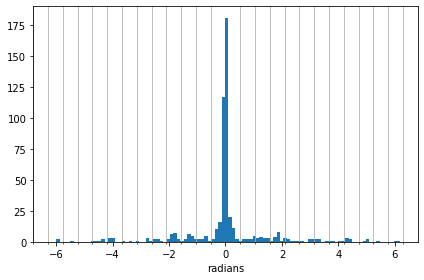

In [11]:
res = np.array(results)

fig, ax = plt.subplots(1,1)

ax.hist(res[:,2], bins=100)

tick_lines = np.deg2rad(30)*np.arange(-13, 13)
ax.set_xticks(tick_lines, minor=True)
ax.grid(True, axis='both', which='minor')
ax.set_xlabel('radians')

fig.tight_layout()
fig.savefig(f"{path}/residual_angle.png")

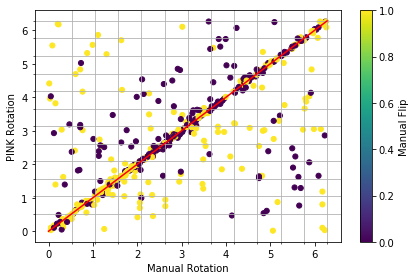

In [12]:
res = np.array(results)

fig, ax = plt.subplots(1,1)

cim = ax.scatter(res[:, 1], res[:, 4], c=res[:,0], s=26)

ax.set(xlabel='Manual Rotation', ylabel='PINK Rotation')

tick_lines = np.deg2rad(30)*np.arange(-1, 13)
ax.set_xticks(tick_lines, minor=True)
ax.set_yticks(tick_lines, minor=True)

ax.grid(True, axis='both', which='minor')

one = np.linspace(0, 2*np.pi)
ax.plot(one, one, 'r-')

fig.colorbar(cim, label='Manual Flip')

fig.tight_layout()
fig.savefig('Images/Manual_PINK_Angle.png')

In [13]:
catalogue = Table.read('../Data/10_field_emu/aegean/aegean_comp.fits').to_pandas()

catalogue['uuid'] = catalogue['uuid'].str.decode("utf-8")

catalogue

,island,source,background,local_rms,ra_str,dec_str,ra,err_ra,dec,err_dec,...,err_b,pa,err_pa,flags,residual_mean,residual_std,uuid,psf_a,psf_b,psf_pa
0,1,0,2.735007e-06,0.000063,b'22:16:30.58',b'-63:01:26.45',334.127411,0.000031,-63.024014,0.000008,...,0.055042,-61.205288,0.298315,0,-6.266882e-06,0.000074,17faf6f9-0d47-4faa-9bc8-c8581dc72f49,14.78397,11.051587,-59.004898
1,2,0,-8.031109e-07,0.000061,b'22:15:13.15',b'-63:04:28.70',333.804779,0.000484,-63.074638,0.000108,...,1.199520,27.375042,2.564502,0,-3.090008e-06,0.000008,e786514c-a154-4c23-bcbe-c13ff45d0935,14.78397,11.051587,-59.004898
2,3,0,-2.616467e-06,0.000060,b'22:16:05.38',b'-63:01:14.67',334.022400,0.000115,-63.020741,0.000028,...,0.217276,-60.033047,0.843523,0,-5.192538e-06,0.000050,86eeb9f9-fb3c-4703-8657-1800d758d528,14.78397,11.051587,-59.004898
3,4,0,1.788521e-06,0.000062,b'22:17:25.58',b'-62:57:46.30',334.356598,0.000030,-62.962860,0.000009,...,0.042448,-59.288612,0.015803,0,-3.987740e-05,0.000311,faaa3d9d-79c3-4fbe-87fc-094bc8419816,14.78397,11.051587,-59.004898
4,5,0,3.743040e-06,0.000062,b'22:17:33.75',b'-62:57:38.63',334.390625,0.000372,-62.960732,0.000088,...,0.810359,28.507483,1.088374,0,-1.395770e-06,0.000010,34443f11-2d6e-4a38-9cd0-d0a0c305d7d4,14.78397,11.051587,-59.004898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251540,241146,0,4.826535e-06,0.000075,b'20:40:07.02',b'-48:14:02.38',310.029266,0.000186,-48.233994,0.000052,...,0.205064,-60.575142,1.007008,0,-5.707773e-07,0.000015,13f99809-5553-4e21-a80a-d807d66147cb,14.78397,11.051587,-59.004898
251541,241147,0,-1.538268e-06,0.000068,b'20:47:44.94',b'-48:13:42.58',311.937225,0.000468,-48.228493,0.000106,...,0.595964,-60.183002,0.790698,0,-1.184319e-06,0.000010,b2b53daf-1ebd-4bd3-a42f-dbc302b1da5c,14.78397,11.051587,-59.004898
251542,241148,0,-1.310643e-05,0.000070,b'20:43:14.11',b'-48:14:00.87',310.808777,0.000487,-48.233574,0.000228,...,1.401948,32.186440,0.322078,0,-1.635617e-05,0.000041,4f0fd1db-31c8-4c6c-a115-3700485b98ad,14.78397,11.051587,-59.004898
251543,241149,0,-5.591048e-06,0.000070,b'20:34:15.10',b'-48:12:16.39',308.562927,0.000200,-48.204552,0.000066,...,0.288276,34.057232,0.526203,0,-1.807150e-05,0.000059,4808f445-c4f7-4346-9f8f-131cb1296ed0,14.78397,11.051587,-59.004898


In [14]:
uuid_keys = [i for i in imgs.records]

emu_positions = SkyCoord(catalogue['ra']*u.deg, catalogue['dec']*u.deg)

# Reorders catalogue to the order images went into PINK image file
sub_cata = catalogue.set_index(keys='uuid',).loc[uuid_keys]

sky_positions = SkyCoord(sub_cata['ra']*u.deg, sub_cata['dec']*u.deg)

In [15]:
sky_matches = search_around_sky(sky_positions, sky_positions, seplimit=5*u.arcminute/2)
emu_sky_matches = search_around_sky(sky_positions, emu_positions, seplimit=5*u.arcminute/2)

In [16]:
plt.close('all')

bmu_keys = mapper.bmu(return_idx=True, squeeze=True)
bz, by, bx = bmu_keys.T

for i, k in enumerate(som):   
    mask = ((k[0] == by) & (k[1] == bx))
    argmask = np.argwhere(mask)

    print(i, k, np.sum(mask))
    
    for j, src in enumerate(argmask):
        if j > 2:
            break
        
        src = src[0]
        
        center_pos = sky_positions[src]
        src_mask = src == sky_matches[0]
        src_matches = sky_matches[1][src_mask]   
        
        emu_mask = src == emu_sky_matches[0]
        emu_matches = emu_sky_matches[1][emu_mask]
        
        bmu_min = k
        
        mapper_bmu =  tuple(mapper.bmu(src))
        assert bmu_min == mapper_bmu
        
        trans_key = (src, *k)
        flip, angle = transform.data[trans_key]
        src_transform = (flip, angle)
        
        wcs_custom = imgs.records[src][1]
        
        spatial_emu_pos = pu.CoordinateTransformer(center_pos,
                                               emu_positions[emu_matches],
                                               src_transform,
                                                pixel_scale=2*u.arcsecond)
        
        src_img = imgs.data[src, 0].copy()
        transform_img = pu.pink_spatial_transform(src_img, src_transform)
    
        fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize=(10, 3))
        
        ax.imshow(src_img)
        ax1.imshow(transform_img)
        ax2.imshow(som[k][0][32:-33, 32:-33])

        ax.plot(spatial_emu_pos.coords['offsets-pixel'][0].value + 75, 
                spatial_emu_pos.coords['offsets-pixel'][1].value + 75,
                'ro')
        
        ax1.plot(spatial_emu_pos.coords['offsets-neuron'][0].value + 75, 
                spatial_emu_pos.coords['offsets-neuron'][1].value + 75,
                'ro')
        
        ax2.plot(spatial_emu_pos.coords['offsets-neuron'][0].value + 75, 
                spatial_emu_pos.coords['offsets-neuron'][1].value + 75,
                'ro')
        
        
        ax.set(title=f"{k} {np.sum(mask)}")
        ax1.set(title=f"{src_transform}")
        
        fig.tight_layout()
        fig.savefig(f'{path.Overlay}/{k}_{j}.png')
        
        plt.close(fig)
        
print('Done')

0 (0, 0) 351
1 (0, 1) 333
2 (0, 2) 512
3 (0, 3) 126
4 (0, 4) 646
5 (0, 5) 441
6 (0, 6) 362
7 (0, 7) 419
8 (1, 0) 337
9 (1, 1) 323
10 (1, 2) 371
11 (1, 3) 408
12 (1, 4) 172
13 (1, 5) 377
14 (1, 6) 322
15 (1, 7) 359
16 (2, 0) 396
17 (2, 1) 348
18 (2, 2) 102
19 (2, 3) 321
20 (2, 4) 509
21 (2, 5) 435
22 (2, 6) 357
23 (2, 7) 470
24 (3, 0) 256
25 (3, 1) 255
26 (3, 2) 186
27 (3, 3) 374
28 (3, 4) 161
29 (3, 5) 466
30 (3, 6) 378
31 (3, 7) 428
32 (4, 0) 344
33 (4, 1) 235
34 (4, 2) 214
35 (4, 3) 261
36 (4, 4) 325
37 (4, 5) 558
38 (4, 6) 302
39 (4, 7) 294
40 (5, 0) 284
41 (5, 1) 273
42 (5, 2) 307
43 (5, 3) 442
44 (5, 4) 340
45 (5, 5) 221
46 (5, 6) 319
47 (5, 7) 297
48 (6, 0) 327
49 (6, 1) 271
50 (6, 2) 388
51 (6, 3) 289
52 (6, 4) 356
53 (6, 5) 410
54 (6, 6) 318
55 (6, 7) 240
56 (7, 0) 349
57 (7, 1) 187
58 (7, 2) 239
59 (7, 3) 279
60 (7, 4) 374
61 (7, 5) 401
62 (7, 6) 367
63 (7, 7) 325
Done


In [17]:
plt.close('all')

bmu_keys = mapper.bmu(return_idx=True, squeeze=True)
bz, by, bx = bmu_keys.T

for i, k in enumerate(som):       
    mask = ((k[0] == by) & (k[1] == bx))
    argmask = np.argwhere(mask)

    if np.sum(mask) == 0:
        continue
    
    print(i, k, np.sum(mask))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
    
    ax1.imshow(som[k][0], cmap='Greys')
    ax2.imshow(som[k][0], cmap='Greys')
    
    ax1.set(title=f"{k} - {np.sum(mask)}")
    
    divider = make_axes_locatable(ax2)
    axHistx = divider.append_axes('top', size='23%', pad='2%', sharex=ax2)
    axHisty = divider.append_axes('right', size='23%', pad='2%', sharey=ax2)
    
    spatial_pos = []
    
    for j, src in enumerate(argmask):        
        src = src[0]
        
        center_pos = sky_positions[src]
        src_mask = src == sky_matches[0]
        src_matches = sky_matches[1][src_mask]   
        
        emu_mask = src == emu_sky_matches[0]
        emu_matches = emu_sky_matches[1][emu_mask]
        
        bmu_min = k
        
        mapper_bmu =  tuple(mapper.bmu(src))
        assert bmu_min == mapper_bmu
        
        transform_key = (src, *k)
        src_transform = transform.data[transform_key]
        flip, angle = src_transform

        spatial_emu_pos = pu.CoordinateTransformer(center_pos,
                                               emu_positions[emu_matches],
                                               src_transform,
                                                pixel_scale=2*u.arcsecond)
        
        spatial_pos.append(spatial_emu_pos)
        

    px = np.concatenate([pos.coords['offsets-neuron'][0].value for pos in spatial_pos]).flatten() + 213/2
    py = np.concatenate([pos.coords['offsets-neuron'][1].value for pos in spatial_pos]).flatten() + 213/2
    
    ax2.plot(px, 
             py,
             'ro',
             markersize=1.5)
        
    axHistx.hist(px, bins=30, density=True, histtype='stepfilled', alpha=0.7)
    axHisty.hist(py, bins=30, density=True, orientation='horizontal', histtype='stepfilled', alpha=0.7)
    axHistx.set(ylabel='Density')
    axHisty.set(xlabel='Density')
    
    # no labels
    plt.setp(axHistx.get_xticklabels(), visible=False)
    plt.setp(axHisty.get_yticklabels(), visible=False)
    
    fig.tight_layout()
    fig.savefig(f'{path.Cluster}/{k}_cluster.png')

    
    plt.close(fig)
        
print('Done')

0 (0, 0) 351
1 (0, 1) 333
2 (0, 2) 512
3 (0, 3) 126
4 (0, 4) 646
5 (0, 5) 441
6 (0, 6) 362
7 (0, 7) 419
8 (1, 0) 337
9 (1, 1) 323
10 (1, 2) 371
11 (1, 3) 408
12 (1, 4) 172
13 (1, 5) 377
14 (1, 6) 322
15 (1, 7) 359
16 (2, 0) 396
17 (2, 1) 348
18 (2, 2) 102
19 (2, 3) 321
20 (2, 4) 509
21 (2, 5) 435
22 (2, 6) 357
23 (2, 7) 470
24 (3, 0) 256
25 (3, 1) 255
26 (3, 2) 186
27 (3, 3) 374
28 (3, 4) 161
29 (3, 5) 466
30 (3, 6) 378
31 (3, 7) 428
32 (4, 0) 344
33 (4, 1) 235
34 (4, 2) 214
35 (4, 3) 261
36 (4, 4) 325
37 (4, 5) 558
38 (4, 6) 302
39 (4, 7) 294
40 (5, 0) 284
41 (5, 1) 273
42 (5, 2) 307
43 (5, 3) 442
44 (5, 4) 340
45 (5, 5) 221
46 (5, 6) 319
47 (5, 7) 297
48 (6, 0) 327
49 (6, 1) 271
50 (6, 2) 388
51 (6, 3) 289
52 (6, 4) 356
53 (6, 5) 410
54 (6, 6) 318
55 (6, 7) 240
56 (7, 0) 349
57 (7, 1) 187
58 (7, 2) 239
59 (7, 3) 279
60 (7, 4) 374
61 (7, 5) 401
62 (7, 6) 367
63 (7, 7) 325
Done
